In [11]:
import numpy as np
import matplotlib.pyplot as plt
from linearPolicy import linearPolicyLearner
import pickle
import pandas as pd
import numpy as np
from tqdm.notebook import trange
from POEMPolicy import linearPOEMPolicyLearner

In [2]:
class Configuration(object):
    def __init__(self):
        self.p = 5
        self.k = 3
        self.f1 = 0
        self.f2 = 1
        self.sigma_list = np.array([0.8,0.4,0.2])
        self.exp_list = np.array([[1,0,0],  # Region 0
                                  [0,1,0],  # Region 1
                                  [0,0,1]]) # Region 2
        self.vec_list = np.array([[0,0,0,0,0],  # Region 0
                                  [0,0,0,0,0],  # Region 1
                                  [0,0,0,0,0]]) # Region 2
        self.pi0 = np.array([[0.5,0.25,0.25],  # Region 0
                            [0.3,0.4,0.3],   # Region 1
                            [0.3,0.3,0.4]])  # Region 2
        assert self.k == self.sigma_list.shape[0]

class dataGeneratorComplex(object):
    # DATA GENERATION CLASS
    def __init__(self, config):
        self.p = config.p
        self.k = config.k
        self.f1 = config.f1
        self.f2 = config.f2
        self.exp_list = config.exp_list
        self.sigma_list = config.sigma_list
        self.pi0 = config.pi0
        
    def generate_features(self, num):
        return np.random.uniform(low=-1.0, high=1.0, size=(num, self.p))
    
    def generate_best_actions(self, features):
        exp_rewards_mat = self.generate_exp_reward_mat(features)
        return np.argmax(exp_rewards_mat, axis = 1)
        
    def generate_actions(self, features):
        num = features.shape[0]
        pi_mat = self.generate_pi_mat(features)
        best_acts = self.generate_best_actions(features)
        tmp = np.random.uniform(size = (num))
        actions = np.zeros(num).astype(np.int)
        for region in range(self.k):
            idx = (best_acts == region)
            prob_mat = np.ones((np.sum(idx),self.k))*np.cumsum(pi_mat[region,:])
            actions[idx] = np.sum((tmp[idx] < prob_mat.T).T, axis = 1) - 1
        return actions

    def generate_exp_reward_mat(self, features):
        num = features.shape[0]
        subfeatures = features[:, (self.f1, self.f2)]
        result = np.zeros((num,self.k))
        result[:,0] = 0.2*features[:,self.f1]
        result[:,1] = 1 - 1*np.linalg.norm(subfeatures - (-0.5,1), axis=1)
        result[:,2] = 1 - 1*np.linalg.norm(subfeatures - (-0.5,-1), axis=1)
        return result
        
    def generate_reward_mat(self, features):
        num = features.shape[0]
        res = self.generate_exp_reward_mat(features) + self.sigma_list * np.random.randn(num, self.k)
        return res
    
    def generate_pi_mat(self, features):
        num = features.shape[0]
        opt_actions = self.generate_best_actions(features)
        pi_mat = self.pi0[opt_actions,:]
        return pi_mat
    
    def generate_all_data(self, n_exp):
        features_mat = self.generate_features(n_exp)
        opt_actions = self.generate_best_actions(features_mat)

        actions = self.generate_actions(features_mat)
        exp_rewards_mat = self.generate_exp_reward_mat(features_mat)
        rewards_mat = self.generate_reward_mat(features_mat)
        pi_mat = self.generate_pi_mat(features_mat)

        IPW_mat = np.zeros_like(rewards_mat)
        IPW_mat[np.arange(n_exp),actions.astype(np.int)] = \
        (rewards_mat/pi_mat)[np.arange(n_exp),actions.astype(np.int)]

        AIPW_mat = np.zeros_like(rewards_mat)
        AIPW_mean = np.mean(IPW_mat, axis = 0)
        AIPW_mat = AIPW_mat + AIPW_mean
        AIPW_mat[np.arange(n_exp),actions.astype(np.int)] += \
        ((rewards_mat - AIPW_mean)/pi_mat)[np.arange(n_exp),actions.astype(np.int)]

        return (features_mat, opt_actions, actions, 
            exp_rewards_mat, rewards_mat, pi_mat,
            IPW_mat, AIPW_mat)

In [3]:
def plot_region(features_mat, opt_actions, alpha = 0.8):
    plt.rcParams['figure.figsize'] = [8, 8]
    fig, ax = plt.subplots()
    scatter = ax.scatter(x = features_mat[opt_actions == 0,config.f1], 
                         y = features_mat[opt_actions == 0,config.f2],
                         alpha = alpha)
    scatter = ax.scatter(x = features_mat[opt_actions == 1,config.f1], 
                         y = features_mat[opt_actions == 1,config.f2],
                         alpha = alpha)
    scatter = ax.scatter(x = features_mat[opt_actions == 2,config.f1], 
                         y = features_mat[opt_actions == 2,config.f2],
                         alpha = alpha)
    legend1 = ax.legend(("Region 0","Region 1","Region 2"),
                        loc="lower right", fontsize = 16)
    ax.add_artist(legend1)
    
    plt.xlabel("$x_{}$".format(config.f1),fontsize=20)
    plt.ylabel("$x_{}$".format(config.f2),fontsize=20)

def compute_reward(theta, features_mat, rewards_mat):
    num = features_mat.shape[0]
    theta_act = np.argmax(features_mat @ theta, axis = 1)
    regret = np.mean(np.max(rewards_mat, axis = 1) - rewards_mat[np.arange(num), theta_act])
    return np.mean(rewards_mat[np.arange(num), theta_act])

def print_decision_boundary(theta, config):
    p, n = theta.shape
    for i in range(n):
        diff_theta = (theta[:,i] - theta[:,i-1])
        diff_theta = diff_theta/np.linalg.norm(diff_theta/np.sqrt(2))
        print("Decision Boundary:\n")
        string = ""
        for i in range(config.p):
            string = string + "{: .5f} * x_{} + ".format(diff_theta[i],i)
        if p == config.p+1:
            string = string + "{: .5f} = 0".format(diff_theta[-1])
        elif p == config.p:
            string = string + "\b\b = 0"
        else:
            raise ValueError("Wrong theta shape")
        print(string)

[ 0.07992391 -0.56308839 -0.5658094 ]


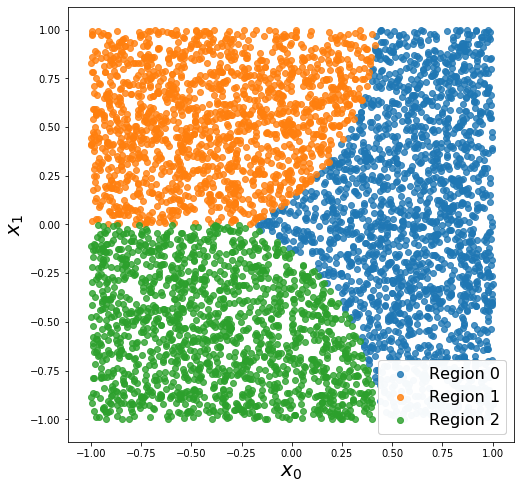

In [4]:
config = Configuration()
n_exp = 5000
data_generator = dataGeneratorComplex(config)

(features_mat, opt_actions, actions, 
 exp_rewards_mat, rewards_mat, pi_mat, 
 IPW_mat, AIPW_mat) = data_generator.generate_all_data(n_exp)
#features_mat = np.column_stack([features_mat,np.ones(features_mat.shape[0])])
features_mat = np.column_stack([features_mat,np.ones(features_mat.shape[0])])
plot_region(features_mat, opt_actions)

print(np.mean(rewards_mat[opt_actions == 0,:], axis = 0))

# Test Non-DRO

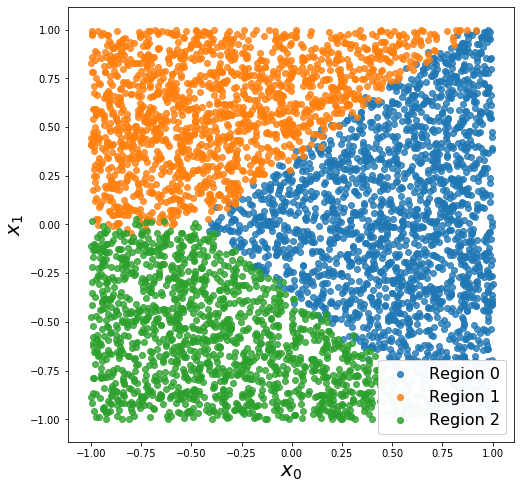

Theta:
 [[ 0.2007802  -0.44305788 -0.41459895]
 [-0.03240368  0.80708575 -0.8061631 ]
 [ 0.03615361  0.0504286   0.00106341]
 [-0.0302835  -0.00170532 -0.01155438]
 [ 0.00638281 -0.02368468  0.01509785]
 [-0.00547491 -0.28933289 -0.2843983 ]]
Decision Boundary:

 0.84655 * x_0 +  1.06442 * x_1 +  0.04827 * x_2 + -0.02576 * x_3 + -0.01199 * x_4 +  0.38370 = 0
Decision Boundary:

-0.83058 * x_0 +  1.08298 * x_1 +  0.01842 * x_2 +  0.03687 * x_3 + -0.03879 * x_4 + -0.36619 = 0
Decision Boundary:

 0.02492 * x_0 + -1.41289 * x_1 + -0.04323 * x_2 + -0.00863 * x_3 +  0.03397 * x_4 +  0.00432 = 0
Reward:
 0.25800482462073115


In [5]:
theta_LR = linearPolicyLearner().linear_regression_policy(features_mat, rewards_mat, actions)
theta_LR_act = np.argmax(features_mat @ theta_LR, axis = 1)
plot_region(features_mat, theta_LR_act)
plt.show()
print("Theta:\n", theta_LR)
print_decision_boundary(theta_LR, config)
print("Reward:\n", compute_reward(theta_LR, features_mat, rewards_mat))

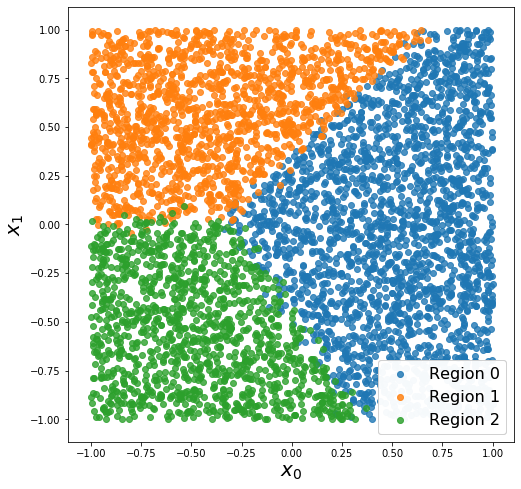

Theta:
 [[ 0.         -7.52595807 -6.68273899]
 [ 0.          7.77940149 -4.07081122]
 [ 0.          0.20538985 -0.29894092]
 [ 0.          0.47645848  0.28129898]
 [ 0.         -0.07570977  0.34031849]
 [ 0.         -2.71154039 -1.91779438]]
Decision Boundary:

 1.17050 * x_0 +  0.71301 * x_1 +  0.05236 * x_2 + -0.04927 * x_3 + -0.05961 * x_4 +  0.33591 = 0
Decision Boundary:

-0.95278 * x_0 +  0.98487 * x_1 +  0.02600 * x_2 +  0.06032 * x_3 + -0.00958 * x_4 + -0.34328 = 0
Decision Boundary:

 0.09999 * x_0 + -1.40520 * x_1 + -0.05980 * x_2 + -0.02314 * x_3 +  0.04933 * x_4 +  0.09412 = 0
Reward:
 0.26266632959144326


In [6]:
theta_logistic = linearPolicyLearner().logistic_policy(features_mat, IPW_mat, reg_param = 0)
theta_logistic_act = np.argmax(features_mat @ theta_logistic, axis = 1)
plot_region(features_mat, theta_logistic_act)
plt.show()
print("Theta:\n", theta_logistic)
print_decision_boundary(theta_logistic, config)
print("Reward:\n", compute_reward(theta_logistic, features_mat, rewards_mat))

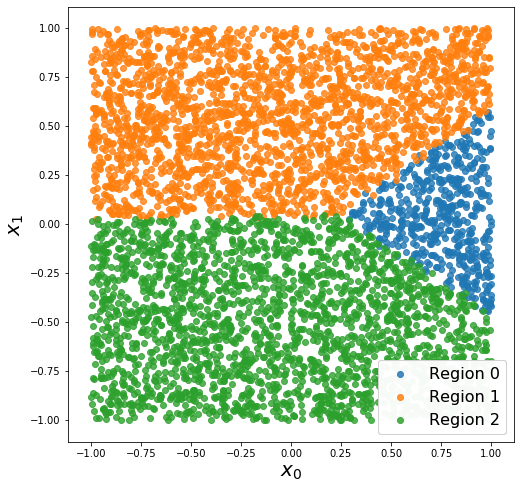

Theta:
 [[ 0.         -1.11749026 -1.0656123 ]
 [ 0.          1.53721362 -1.58775567]
 [ 0.          0.04335803  0.00591919]
 [ 0.         -0.02316163 -0.02856042]
 [ 0.         -0.02554508 -0.03290682]
 [ 0.          0.199524    0.33040763]]
Decision Boundary:

 0.77639 * x_0 +  1.15682 * x_1 + -0.00431 * x_2 +  0.02081 * x_3 +  0.02398 * x_4 + -0.24073 = 0
Decision Boundary:

-0.82667 * x_0 +  1.13717 * x_1 +  0.03207 * x_2 + -0.01713 * x_3 + -0.01890 * x_4 +  0.14760 = 0
Decision Boundary:

 0.02345 * x_0 + -1.41267 * x_1 + -0.01692 * x_2 + -0.00244 * x_3 + -0.00333 * x_4 +  0.05917 = 0
theta_logistic2 Reward:
 -0.9498855108243228
theta_logistic Reward:
 -0.9663425012552455


In [7]:
theta_logistic2 = linearPolicyLearner().logistic_policy_2(
    features_mat, -np.exp(-rewards_mat/1), reg_param = 0, max_iter=1000)
theta_logistic_act2 = np.argmax(features_mat @ theta_logistic2, axis = 1)
plot_region(features_mat, theta_logistic_act2)
plt.show()
print("Theta:\n", theta_logistic2)
print_decision_boundary(theta_logistic2, config)
print("theta_logistic2 Reward:\n", compute_reward(theta_logistic2, features_mat, -np.exp(-rewards_mat/1)))
print("theta_logistic Reward:\n", compute_reward(theta_logistic, features_mat, -np.exp(-rewards_mat/1)))
#print(Q_DRO(theta_logistic2, delta, config, 20000, verbose = True))
#print(Q_DRO(theta_logistic, delta, config, 20000, verbose = True))

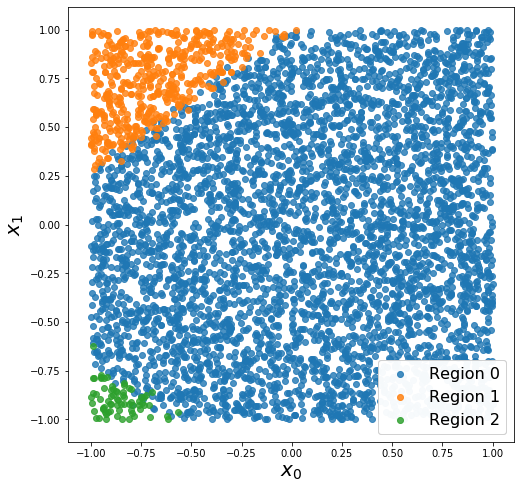

Theta:
 [[ 0.         -0.00954318 -0.00696731]
 [ 0.          0.01259917 -0.0094128 ]
 [ 0.          0.00059334 -0.00058725]
 [ 0.          0.00036232 -0.00027568]
 [ 0.         -0.00038701  0.00034406]
 [ 0.         -0.01276206 -0.0136237 ]]
Decision Boundary:

 0.54801 * x_0 +  0.74035 * x_1 +  0.04619 * x_2 +  0.02168 * x_3 + -0.02706 * x_4 +  1.07156 = 0
Decision Boundary:

-0.66385 * x_0 +  0.87643 * x_1 +  0.04127 * x_2 +  0.02520 * x_3 + -0.02692 * x_4 + -0.88776 = 0
Decision Boundary:

 0.16386 * x_0 + -1.40025 * x_1 + -0.07510 * x_2 + -0.04058 * x_3 +  0.04651 * x_4 + -0.05481 = 0
Reward:
 0.07342491393354912


In [8]:
theta_logistic_stable = linearPolicyLearner().logistic_policy_stable(
    features_mat, rewards_mat, actions, pi_mat, learning_rate = 1, max_iter = 1000, reg_param = 1e-3)
theta_logistic_stable_act = np.argmax(features_mat @ theta_logistic_stable, axis = 1)
plot_region(features_mat, theta_logistic_stable_act)
plt.show()
print("Theta:\n", theta_logistic_stable)
print_decision_boundary(theta_logistic_stable, config)
print("Reward:\n", compute_reward(theta_logistic_stable, features_mat, rewards_mat))

## Test the POEM estimator

0.25816878023718953


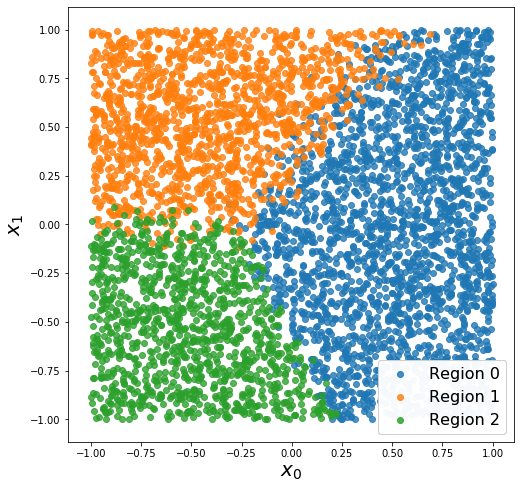

In [9]:
theta_PORM = linearPOEMPolicyLearner().POEM_policy(features_mat, rewards_mat, actions, pi_mat, max_clip=10, var_reg=5,
                                    tol = 1e-7, max_iter = 100, theta_init = None, verbose = True)
theta_POEM_act = np.argmax(features_mat @ theta_PORM, axis = 1)
plot_region(features_mat, theta_POEM_act)
print(compute_reward(theta_PORM, features_mat, rewards_mat))

# Test DRO

# Computation of Theoretical Decision Boundary

we have the optimal DRO policy in the class $\overline{\Pi}$ is
\begin{equation}
\pi^*_\mathrm{\rm DRO}(x) =  \arg\max_{i\in \{ 1,2,\ldots,d\}}\left\{E[Y(i)|X]-\frac{\sigma^2_i}{2\alpha^*(\pi^*_{\rm DRO})}\right\},
\end{equation}
 where $\alpha^*(\pi^*_{\rm DRO})$ is the optimizer of the following optimization problem:
\begin{equation}
\alpha^*(\pi^*_{\rm DRO})=\arg\max_{\alpha \geq 0} \left \{-\alpha \log \mathbb{E}_{P_0}\left [\exp\left(\min_{i\in \{ 1,2,\ldots,d\}}\left\{-\frac{E[Y(i)|X]}{\alpha} +\frac{\sigma^2_i}{\alpha^2} \right\} \right) \right] - \alpha \delta \right \}.
\label{eq:alpha_DRO_small}
\end{equation}

In [10]:
def bayes_optimal_alpha(config, delta, num_sample):
    from scipy.optimize import minimize_scalar
    X = data_generator.generate_features(num_sample)
    sigma_list = config.sigma_list
    scores = data_generator.generate_exp_reward_mat(X)
    def objective(alpha):
        res = (-alpha*np.log(np.mean(
            np.exp(np.min(-(scores/alpha) + (sigma_list**2)/(2*alpha**2), axis = 0))))-alpha*delta)
        return -res
    opt_alpha = minimize_scalar(objective, bounds=[1e-4,1e4], method='bounded')
    if opt_alpha.success:
        return opt_alpha.x
    else:
        print("opt_alpha")
        raise ValueError("optimization fail")

def plot_bayes_boundary(config, bayes_opt_alpha):
    #A = config.vec_list[:-1,:2] - config.vec_list[-1,:2]
    #b = (config.sigma_list[:-1]**2 - config.sigma_list[-1]**2)/(2*bayes_opt_alpha)
    #root = np.linalg.solve(A,b)
    xlist = np.linspace(-1.0, 1.0, 100)
    ylist = np.linspace(-1.0, 1.0, 100)
    X, Y = np.meshgrid(xlist, ylist)
    Z1 = (1-np.sqrt((X+0.5)**2 + (Y+1)**2) - 0.2*X + 
         (config.sigma_list[0]**2 - config.sigma_list[2]**2)/(2*bayes_opt_alpha))
    Z2 = (1-np.sqrt((X+0.5)**2 + (Y-1)**2) - 0.2*X + 
         (config.sigma_list[0]**2 - config.sigma_list[1]**2)/(2*bayes_opt_alpha))
    pltc = plt.contour(X, Y, Z1, [0], colors='black', linewidths = 4, linestyles = 'dashed')
    plt.clabel(pltc, fmt = "Bayes Boundary", fontsize = 14, inline = True, inline_spacing = 1)
    pltc = plt.contour(X, Y, Z2, [0], colors='black', linewidths = 4, linestyles = 'dashed')
    plt.clabel(pltc, fmt = "Bayes Boundary", fontsize = 14, inline = True, inline_spacing = 1)
    #plt.legend(['Optimal Bayes Desicion Boundary'])
    plt.xlim([-1,1])
    plt.ylim([-1,1])

In [11]:
def Q_DRO_alpha(theta, delta, config, num_sample):
    from scipy.optimize import minimize_scalar
    X = data_generator.generate_features(num_sample)
    X = np.column_stack([X,np.ones(X.shape[0])])
    theta_act = np.argmax(X @ theta, axis = 1)
    sigma_list = config.sigma_list
    sample_exp = data_generator.generate_exp_reward_mat(X)[range(num_sample),theta_act]
    sample_sigma = sigma_list[theta_act]
    
    def objective(alpha):
        res = (-alpha*np.log(np.mean(
            np.exp(-(sample_exp/alpha) + (sample_sigma**2)/(2*alpha**2))))-alpha*delta)
        return -res
    
    opt_alpha = minimize_scalar(objective, bounds=[1e-4,1e4], method='bounded')
    if opt_alpha.success:
        return opt_alpha.x
    else:
        print("opt_alpha")
        raise ValueError("optimization fail")

def Q_DRO(theta, delta, config, num_sample, verbose = False):
    alpha = Q_DRO_alpha(theta, delta, config, num_sample)
    if verbose:
        print(alpha)
    features_mat_P_worst = np.array([])
    while features_mat_P_worst.shape[0] < num_sample:
        sigma_list = config.sigma_list
        vec_list = config.vec_list
        k, p = vec_list.shape
        features_mat = np.random.uniform(low=-1.0, high=1.0, size=(num_sample, p))
        scores_mat = data_generator.generate_exp_reward_mat(features_mat)
        X = np.column_stack([features_mat,np.ones(features_mat.shape[0])])
        theta_act = np.argmax(X @ theta, axis = 1)
        unif = np.random.rand(num_sample)
        cond = (np.log(unif) * alpha**2 
                + alpha * (1 + scores_mat[range(num_sample), theta_act])
                + 0.5 * (np.max(sigma_list**2) - sigma_list[theta_act]**2))
        if features_mat_P_worst.shape[0] == 0:
            features_mat_P_worst = features_mat[cond <= 0,:]
        else:
            features_mat_P_worst = np.vstack((features_mat_P_worst, features_mat[cond >= 0,:]))
    features_mat = features_mat_P_worst[:num_sample]
    scores_mat = data_generator.generate_exp_reward_mat(features_mat)
    X = np.column_stack([features_mat,np.ones(features_mat.shape[0])])
    theta_act = np.argmax(X @ theta, axis = 1)
    exp_rewards_mat = (scores_mat - (sigma_list**2/(2*alpha))*np.eye(k)[theta_act,:])
    theta_exp_rewards_list = exp_rewards_mat[range(num_sample), theta_act]
    return np.mean(theta_exp_rewards_list)

1.2628137369352535
[[ 0.07807757  0.09505337 -1.0426061 ]
 [ 0.07124261  0.14298886 -1.14162537]
 [-0.1585382  -0.65860422  0.53024536]
 ...
 [-0.07633671 -0.75860939  0.72758897]
 [-0.17146668  0.6366822  -0.96705782]
 [-0.16322522 -0.16574834  0.06688544]]
[[-0.17532481  0.03170278 -1.05844375]
 [-0.18215977  0.07963826 -1.15746302]
 [-0.41194058 -0.72195482  0.51440771]
 ...
 [-0.32973909 -0.82195998  0.71175132]
 [-0.42486906  0.57333161 -0.98289546]
 [-0.4166276  -0.22909893  0.0510478 ]]
532


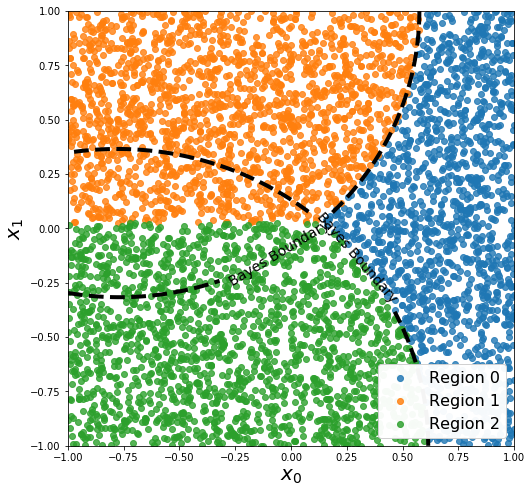

Optimal alpha
 1.2628137369352535


In [12]:
bayes_opt_alpha = bayes_optimal_alpha(config, delta = 0.2, num_sample = 100000)
print(bayes_opt_alpha)
bayes_opt_act = np.argmax(exp_rewards_mat - (config.sigma_list**2)/(2*bayes_opt_alpha), axis = 1)
print(exp_rewards_mat)
print(exp_rewards_mat - (config.sigma_list**2)/(2*bayes_opt_alpha))
plot_region(features_mat, bayes_opt_act)
print(np.sum(bayes_opt_act != opt_actions))
plot_bayes_boundary(config, bayes_opt_alpha)
plt.show()
print("Optimal alpha\n", bayes_opt_alpha)

# Computation of worst case dist (w.r.t. population measure)
The likelihood ratio between the worst case distribution and the population distribution is:
\begin{equation}
\frac{d\mathbf{P}(\pi_{\rm DRO}^{\ast})}{d\mathbf{P}_0}
= c * \exp\big(-Y(\pi_{\rm DRO}^{\ast}(X)) \big/ \alpha^*(\pi^*_{\rm DRO})\big)
\end{equation}

We will use the following likelihood ratio in terms of marginal of X to sample X first, applying acceptance-rejection
\begin{align*}
\mathbb{E}\big[\frac{d\mathbf{P}(\pi_{\rm DRO}^{\ast})}{d\mathbf{P}_0}\big|X\big]
&= c * \mathbb{E}\big[\exp\big(-Y(\pi_{\rm DRO}^{\ast}(X)) \big/ \alpha^*(\pi^*_{\rm DRO})\big)\big|X\big]\\
&= c * \exp\big(-\frac{\mathbb{E}\big[Y(\pi_{\rm DRO}^{\ast}(X))|X\big]}{\alpha^*(\pi^*_{\rm DRO})}
+ \frac{\sigma^2_{\pi^*_{\rm DRO}(X)}}{2(\alpha^*(\pi^*_{\rm DRO}))^2}\big)\\
&\leq c * \exp\big(\frac{1}{\alpha^*(\pi^*_{\rm DRO})} + 
\frac{\sigma^2_{\max}}{2(\alpha^*(\pi^*_{\rm DRO}))^2}\big)
\end{align*}

We accept sample of X if and only if for U~Unif(0,1)

\begin{equation*}
-\frac{\mathbb{E}\big[Y(\pi_{\rm DRO}^{\ast}(X))|X\big]}{\alpha^*(\pi^*_{\rm DRO})}
+ \frac{\sigma^2_{\pi^*_{\rm DRO}(X)}}{2(\alpha^*(\pi^*_{\rm DRO}))^2}
\leq 
\log(U)+\frac{1}{\alpha^*(\pi^*_{\rm DRO})} + 
\frac{\sigma^2_{\max}}{2(\alpha^*(\pi^*_{\rm DRO}))^2}
\end{equation*}
\begin{equation*}
\Leftrightarrow
(\alpha^*(\pi^*_{\rm DRO}))^2 \log(U)+
(\alpha^*(\pi^*_{\rm DRO}))(1+\mathbb{E}\big[Y(\pi_{\rm DRO}^{\ast}(X))|X\big])+ 
\frac{1}{2}(\sigma^2_{\max} - \sigma^2_{\pi^*_{\rm DRO}(X)})
\geq 0
\end{equation*}

Then, we have the conditional distribution of $Y$ given $X$ under $\mathbf{P}(\pi^*_\mathrm{\rm DRO}(x))$ is given by
\begin{align*}
Y(a^{i})|X \sim \mathcal{N}\left(\mathbb{E}\big[Y(\pi_{\rm DRO}^{\ast}(X))|X\big]
-\frac{\sigma^2_i}{2\alpha^*(\pi^*_{\rm DRO})}\mathbf{1}
\{\pi^*_{\rm DRO}(X) = i\}
,\sigma_i^2\right),\text{ for }i=1,\ldots,d.\\
\end{align*}

In [13]:
def sample_worst_dist(config, bayes_opt_alpha, num_sample):
    features_mat_P_worst = np.array([])
    while features_mat_P_worst.shape[0] < num_sample:
        sigma_list = config.sigma_list
        vec_list = config.vec_list
        k, p = vec_list.shape
        alpha = bayes_opt_alpha
        features_mat = np.random.uniform(low=-1.0, high=1.0, size=(num_sample, p))
        scores_mat = data_generator.generate_exp_reward_mat(features_mat)
        bayes_opt_act = np.argmax((scores_mat) - (config.sigma_list**2)/(2*bayes_opt_alpha), axis = 1)
        unif = np.random.rand(num_sample)
        cond = (np.log(unif) * alpha**2 
                + alpha * (1 + scores_mat[range(num_sample), bayes_opt_act])
                + 0.5 * (np.max(sigma_list**2) - sigma_list[bayes_opt_act]**2))
        if features_mat_P_worst.shape[0] == 0:
            features_mat_P_worst = features_mat[cond <= 0,:]
        else:
            features_mat_P_worst = np.vstack((features_mat_P_worst, features_mat[cond >= 0,:]))
    features_mat = features_mat_P_worst[:num_sample]
    scores_mat = data_generator.generate_exp_reward_mat(features_mat)
    bayes_opt_act = np.argmax((scores_mat) - (config.sigma_list**2)/(2*bayes_opt_alpha), axis = 1)
    rewards_mat = ((scores_mat - (sigma_list**2/(2*alpha))*np.eye(k)[bayes_opt_act,:]) 
                   + sigma_list * np.random.randn(num_sample, k))
    return features_mat, rewards_mat

**Sanity Check:** We employ logistic loss to train a multilinear policy under $\mathbf{P}(\pi^*_\mathrm{\rm DRO}(x))$, and compare it with the optimal Bayes policy:

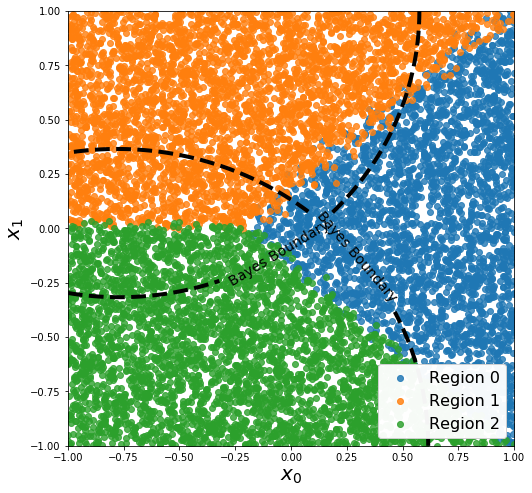

Theta:
 [[ 0.         -1.51440632 -1.5474529 ]
 [ 0.          1.77907678 -1.76523824]
 [ 0.          0.12390119  0.08087246]
 [ 0.          0.11750509  0.05688435]
 [ 0.          0.02032245  0.02268912]
 [ 0.         -0.31491018 -0.28149453]]
Decision Boundary:

 0.92476 * x_0 +  1.05491 * x_1 + -0.04833 * x_2 + -0.03399 * x_3 + -0.01356 * x_4 +  0.16822 = 0
Decision Boundary:

-0.90606 * x_0 +  1.06441 * x_1 +  0.07413 * x_2 +  0.07030 * x_3 +  0.01216 * x_4 + -0.18841 = 0
Decision Boundary:

-0.01318 * x_0 + -1.41378 * x_1 + -0.01716 * x_2 + -0.02418 * x_3 +  0.00094 * x_4 +  0.01333 = 0
Reward:
 0.17902470124477485


In [14]:
features_mat_worst, rewards_mat_worst = sample_worst_dist(config, bayes_opt_alpha, 10000)
features_mat_worst = np.column_stack([features_mat_worst,np.ones(features_mat_worst.shape[0])])
theta_worst = linearPolicyLearner().logistic_policy(features_mat_worst, rewards_mat_worst, reg_param = 0.01)
theta_worst_act = np.argmax(features_mat_worst @ theta_worst, axis = 1)
plot_region(features_mat_worst, theta_worst_act)
plot_bayes_boundary(config, bayes_opt_alpha)
plt.show()
print("Theta:\n", theta_worst)
print_decision_boundary(theta_worst, config)
print("Reward:\n", compute_reward(theta_worst, features_mat_worst, rewards_mat_worst))

## DRO estimator with full info

\begin{align*}
\max_{\pi}\inf_{P\in\mathcal{U}_{P_0}(\delta)} E_{P}[Y(\pi(X))]
\end{align*}

iter=0,  alpha=0.6071, DR_reward = -0.2490
iter=1,  alpha=0.7328, DR_reward = -0.1927
iter=2,  alpha=0.7814, DR_reward = -0.1755
iter=3,  alpha=0.7989, DR_reward = -0.1748
iter=4,  alpha=0.8029, DR_reward = -0.1693
iter=5,  alpha=0.8063, DR_reward = -0.1625
iter=6,  alpha=0.8091, DR_reward = -0.1592
iter=7,  alpha=0.8149, DR_reward = -0.1582
iter=8,  alpha=0.8145, DR_reward = -0.1564
iter=9,  alpha=0.8149, DR_reward = -0.1562
iter=10,  alpha=0.8150, DR_reward = -0.1561
iter=11,  alpha=0.8153, DR_reward = -0.1560
iter=12,  alpha=0.8150, DR_reward = -0.1556
iter=13,  alpha=0.8150, DR_reward = -0.1556
iter=14,  alpha=0.8150, DR_reward = -0.1556
Early break...
Theta:
 [[ 0.         -1.30046078 -1.2154653 ]
 [ 0.          1.89910707 -1.99060766]
 [ 0.          0.06604756  0.01796564]
 [ 0.         -0.04951219 -0.05921394]
 [ 0.         -0.03638641 -0.05369721]
 [ 0.          0.36627495  0.56520931]]
Decision Boundary:

 0.71584 * x_0 +  1.17236 * x_1 + -0.01058 * x_2 +  0.03487 * x_3 +  0.0

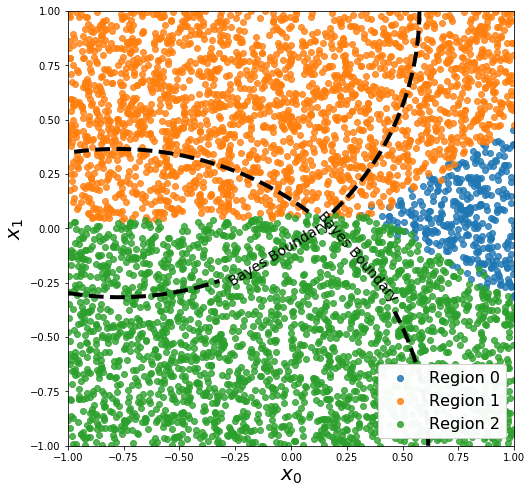

In [15]:
delta = 0.2
alpha_init = 0.2/np.sqrt(delta) 
DR_theta_logistic = linearPolicyLearner().DR_logistic_policy(
    features_mat, rewards_mat, delta = delta, reg_param = 0, alpha_init = alpha_init)
DR_theta_logistic_act = np.argmax(features_mat @ DR_theta_logistic, axis = 1)
plot_region(features_mat, DR_theta_logistic_act)
print("Theta:\n", DR_theta_logistic)
print_decision_boundary(DR_theta_logistic,config)
plot_bayes_boundary(config, bayes_opt_alpha)
print("Reward:\n", compute_reward(DR_theta_logistic, features_mat, exp_rewards_mat))

## DRO Estimator Divided by Sum of indicators

iter=0,  alpha=0.8682, DR_reward = -0.2357
iter=1,  alpha=1.0340, DR_reward = -0.1798
iter=2,  alpha=1.1099, DR_reward = -0.1643
iter=3,  alpha=1.1206, DR_reward = -0.1629
iter=4,  alpha=1.1207, DR_reward = -0.1628
iter=5,  alpha=1.1207, DR_reward = -0.1628
Early break...
Theta:
 [[ 0.         -7.5304278  -6.68826863]
 [ 0.          7.7807834  -4.07886947]
 [ 0.          0.20914802 -0.29737503]
 [ 0.          0.47814449  0.28360477]
 [ 0.         -0.07567173  0.34179423]
 [ 0.         -2.68280788 -1.88481222]]
Decision Boundary:

 1.17132 * x_0 +  0.71434 * x_1 +  0.05208 * x_2 + -0.04967 * x_3 + -0.05986 * x_4 +  0.33009 = 0
Decision Boundary:

-0.95359 * x_0 +  0.98529 * x_1 +  0.02648 * x_2 +  0.06055 * x_3 + -0.00958 * x_4 + -0.33973 = 0
Decision Boundary:

 0.09978 * x_0 + -1.40518 * x_1 + -0.06001 * x_2 + -0.02305 * x_3 +  0.04946 * x_4 +  0.09455 = 0
Reward:
 0.2700901629205446


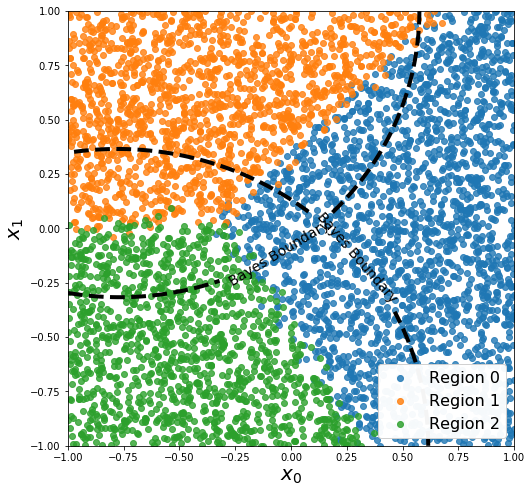

In [16]:
delta = 0.2
alpha_init = 0.3/np.sqrt(delta)
DR_ind_theta_logistic_stable = linearPolicyLearner().DR_ind_logistic_policy_stable(
    features_mat, rewards_mat, actions, pi_mat, delta = delta, alpha_init = alpha_init, reg_param = 0)
DR_ind_theta_logistic_act_stable = np.argmax(features_mat @ DR_ind_theta_logistic_stable, axis = 1)
plot_region(features_mat, DR_ind_theta_logistic_act_stable)
print("Theta:\n", DR_ind_theta_logistic_stable)
print_decision_boundary(DR_ind_theta_logistic_stable,config)
plot_bayes_boundary(config, bayes_opt_alpha)
print("Reward:\n", compute_reward(DR_ind_theta_logistic_stable, features_mat, exp_rewards_mat))

# Test Adversarial Performance

In [17]:
delta = 0.2
print(Q_DRO(theta_LR, delta, config, 20000, verbose = True))
print(Q_DRO(theta_logistic, delta, config, 20000, verbose = True))
print(Q_DRO(DR_theta_logistic, delta, config, 20000, verbose = True))
print(Q_DRO(DR_ind_theta_logistic_stable, delta, config, 20000, verbose = True))

1.0892130081236062
0.11821719952468047
1.1231385903715647
0.11463001341187373
0.8113928144310281
0.08916372053113827
1.1186021328811617
0.10936790057958169


In [18]:
def weights_generation(delta, sample_num, dist_Y = "normal"):
    from scipy.optimize import minimize_scalar
    last_reward = np.inf
    if dist_Y == "chisquare":
        Y = np.random.chisquare(1, sample_num)
    elif dist_Y == "normal":
        Y = np.random.normal(size = sample_num)
    else:
        raise ValueError("unknown dist_Y: {}".format(dist_Y))
    def objective(alpha):
        res = (-alpha*np.log(np.mean(np.exp(-Y/alpha)))-alpha*delta)
        return -res
    opt_alpha = minimize_scalar(objective, bounds=[1e-4,1e4], method='bounded')
    if not opt_alpha.success:
        raise ValueError("optimization fail")
    alpha = opt_alpha.x
    P = np.exp(-Y/alpha) / np.sum(np.exp(-Y/alpha))
    return P
def Q_worst_on_sphere(theta, delta, random_dist_num, n_test):
    features_mat = data_generator.generate_features(n_test)
    rewards_mat = data_generator.generate_reward_mat(features_mat)
    features_mat = np.column_stack([features_mat,np.ones(features_mat.shape[0])])
    sample_num = features_mat.shape[0]
    theta_act = np.argmax(features_mat @ theta, axis = 1)
    rewards_list = rewards_mat[np.arange(sample_num), theta_act]
    res_list = np.zeros(random_dist_num)
    for i in range(random_dist_num):
        P = weights_generation(delta, sample_num, dist_Y = "normal")
        res_list[i] = P @ rewards_list
    #plt.hist(res_list, 100)
    return np.min(res_list)
#Q_worst_on_sphere(DR_theta_logistic, delta = 0.2, random_dist_num = 1000, n_test = 2500)

In [27]:
def QDRO_experiment_multitest_delta(n_train = 1000, n_test = 10000, n_exp = 100, delta = 0.2, test_deltas = [0.2], 
                                    reg_param = 1e-3, max_clip=10, var_reg=0.05):
    """
    def compute_reward(theta, features_mat, rewards_mat):
        num = features_mat.shape[0]
        theta_act = np.argmax(features_mat @ theta, axis = 1)
        return np.mean(rewards_mat[np.arange(num), theta_act])
    """
    config = Configuration()
    data_generator = dataGeneratorComplex(config)
    
    # Generate worst-case test dist
    bayes_opt_alpha = bayes_optimal_alpha(config, delta = delta, num_sample = n_test)
    print(bayes_opt_alpha)
    features_mat_worst, rewards_mat_worst = sample_worst_dist(config, bayes_opt_alpha, n_test)
    features_mat_worst = np.column_stack([features_mat_worst,np.ones(features_mat_worst.shape[0])])
    
    reward_logistic, reward_DR, reward_DR_ind_stable, reward_POEM = {}, {}, {}, {}

    n_test_delta = len(test_deltas)
    reward_logistic['QDRO'], reward_logistic['QMIN'] = np.zeros((n_exp,n_test_delta)), np.zeros((n_exp,n_test_delta))
    reward_DR['QDRO'], reward_DR['QMIN'] = np.zeros((n_exp,n_test_delta)), np.zeros((n_exp,n_test_delta))
    reward_DR_ind_stable['QDRO'], reward_DR_ind_stable['QMIN'] = np.zeros((n_exp,n_test_delta)), np.zeros((n_exp,n_test_delta))
    reward_POEM['QDRO'], reward_POEM['QMIN'] = np.zeros((n_exp,n_test_delta)), np.zeros((n_exp,n_test_delta))
    
    
    for i in trange(n_exp):
        (features_mat, opt_actions, actions, 
         exp_rewards_mat, rewards_mat, pi_mat, 
         IPW_mat, AIPW_mat) = data_generator.generate_all_data(n_train)
        features_mat = np.column_stack([features_mat,np.ones(features_mat.shape[0])])
        
        #theta_LR = linearPolicyLearner().linear_regression_policy(features_mat, rewards_mat, actions)
        theta_logistic = linearPolicyLearner().logistic_policy(features_mat, IPW_mat, reg_param = reg_param)
        DR_theta_logistic = linearPolicyLearner().DR_logistic_policy(
            features_mat, rewards_mat, delta = delta, reg_param = reg_param, 
            alpha_init = 0.2/np.sqrt(delta), verbose = False)
        DR_ind_theta_logistic_stable = linearPolicyLearner().DR_ind_logistic_policy_stable(
            features_mat, rewards_mat, actions, pi_mat, delta = delta, 
            alpha_init = 0.3/np.sqrt(delta), reg_param = reg_param, verbose = False)
        theta_PORM = linearPOEMPolicyLearner().POEM_policy(features_mat, rewards_mat, actions, pi_mat,
                                                           max_clip=max_clip, var_reg=var_reg,
                                                           tol = 1e-7, max_iter = 100, 
                                                           theta_init = None, verbose = False)
        
        for j, test_delta in enumerate(test_deltas):
            #reward_LR['QDRO'][i] = Q_DRO(theta_LR, delta, config, n_test)
            reward_logistic['QDRO'][i][j] = Q_DRO(theta_logistic, test_delta, config, n_test)
            reward_DR['QDRO'][i][j] = Q_DRO(DR_theta_logistic, test_delta, config, n_test)
            reward_DR_ind_stable['QDRO'][i][j] = Q_DRO(DR_ind_theta_logistic_stable, test_delta, config, n_test)
            reward_POEM['QDRO'][i][j] = Q_DRO(theta_PORM, test_delta, config, n_test)

            #reward_LR['QMIN'][i] = Q_worst_on_sphere(
            #    theta_LR, delta, random_dist_num = 100, n_test = n_test)
            reward_logistic['QMIN'][i][j] = Q_worst_on_sphere(
                theta_logistic, test_delta, random_dist_num = 100, n_test = n_test)
            reward_DR['QMIN'][i][j] = Q_worst_on_sphere(
                DR_theta_logistic, test_delta, random_dist_num = 100, n_test = n_test)
            reward_DR_ind_stable['QMIN'][i][j] = Q_worst_on_sphere(
                DR_ind_theta_logistic_stable, test_delta, random_dist_num = 100, n_test = n_test)
            reward_POEM['QMIN'][i][j] = Q_worst_on_sphere(
                theta_PORM, test_delta, random_dist_num = 100, n_test = n_test)
    
    reward_res = (reward_logistic, reward_DR, reward_DR_ind_stable,reward_POEM)
    file = open("./result/linear/multitest_delta_ntrain_{}_delta_{}_reg_{}".format(n_train, delta, reg_param), 'wb')
    pickle.dump(reward_res, file)
    file.close()

In [28]:
QDRO_experiment_multitest_delta(n_train = 2500, n_test = 2500, delta = 0.2, test_deltas = [0.01,0.02,0.05,0.1,0.2,0.3,0.4], n_exp = 100)

1.2531067834226102


In [30]:
file = open("./result/linear/multitest_delta_ntrain_{}_delta_{}_reg_{}".format(2500, 0.2, 1e-3), 'rb')
res = pickle.load(file)

In [17]:
def read_res_table_multi_env_test(n_train = 2500, n_test = 2500,
                                  delta = 0.2, test_deltas = [0.01,0.02,0.05,0.1,0.2,0.3,0.4], var_reg = 0.1):
    import pandas as pd
    import pickle
    file = open("./result/linear/multitest_delta_ntrain_{}_delta_{}_reg_{}".format(2500, 0.2, 1e-3), 'rb')
    res = pickle.load(file)
    table_list = []
    for i, model_name in enumerate(['linear', 'DR', 'DR_stable', 'POEM']):
        temp_table = pd.DataFrame(res[i]['QDRO'], columns = test_deltas)
        temp_table['model'] = model_name
        temp_table['eval'] = 'QDRO'
        table_list.append(temp_table)
        temp_table = pd.DataFrame(res[i]['QMIN'], columns = test_deltas)
        temp_table['model'] = model_name
        temp_table['eval'] = 'QMIN'
        table_list.append(temp_table)
    res_table = pd.concat(table_list, ignore_index = True)
    return res_table
res_table = read_res_table_multi_env_test()

In [18]:
res_table[res_table['model'] == 'linear'].groupby('eval').mean().loc['QDRO'].values
res_table[res_table['model'] == 'linear'].groupby('eval').std().loc['QDRO'].values

array([0.00689141, 0.00757977, 0.00809245, 0.00884159, 0.0100678 ,
       0.01156242, 0.01240179])

In [45]:
def print_latex_tabular(res_table, test_deltas = [0.02,0.05,0.1,0.2,0.3,0.4]):
    def to_print_vec(model_name, metric):
        mean_vec = res_table[res_table['model'] == model_name].groupby('eval').mean().loc[metric].values
        std_vec = res_table[res_table['model'] == model_name].groupby('eval').sem().loc[metric].values[:-1]
        res_string = np.vstack((mean_vec,std_vec)).reshape((-1,),order='F')
        return res_string
    print("""\\begin{tabular}{|c|c|c|c|c|c|c|c|}
    \\hline
    \\multicolumn{2}{|c|}{}""" + ('& $\delta = {:.2f}$'*6).format(*test_deltas) + "\\\\ \\hline")
    print("\multirow{3}{*}{$\hat{Q}_{\mathrm{DRO}}$} & $\hat{\pi}_{\mathrm{Lin}}$")
    print(("& ${:.4f}\pm {:.4f}$ "*6).format(*to_print_vec('linear','QDRO')) + '\\\\ \cline{2-8}')
    print("& $\hat{\pi}_{\mathrm{DRO}}$")
    print(("& ${:.4f}\pm {:.4f}$ "*6).format(*to_print_vec('DR_stable','QDRO')) + '\\\\ \cline{2-8}')
    print("& $\hat{\pi}_{\mathrm{POEM}}$")
    print(("& ${:.4f}\pm {:.4f}$ "*6).format(*to_print_vec('POEM','QDRO')) + '\\\\ \hline')
    print("\multirow{3}{*}{$\hat{Q}_{\mathrm{min}}$} & $\hat{\pi}_{\mathrm{Lin}}$")
    print(("& ${:.4f}\pm {:.4f}$ "*6).format(*to_print_vec('linear','QMIN')) + '\\\\ \cline{2-8}')
    print("& $\hat{\pi}_{\mathrm{DRO}}$")
    print(("& ${:.4f}\pm {:.4f}$ "*6).format(*to_print_vec('DR_stable','QMIN')) + '\\\\ \cline{2-8}')
    print("& $\hat{\pi}_{\mathrm{POEM}}$")
    print(("& ${:.4f}\pm {:.4f}$ "*6).format(*to_print_vec('POEM','QMIN')) + '\\\\ \hline')
    print('\end{tabular}')

In [46]:
print_latex_tabular(read_res_table_multi_env_test().iloc[:,1:])

\begin{tabular}{|c|c|c|c|c|c|c|c|}
    \hline
    \multicolumn{2}{|c|}{}& $\delta = 0.02$& $\delta = 0.05$& $\delta = 0.10$& $\delta = 0.20$& $\delta = 0.30$& $\delta = 0.40$\\ \hline
\multirow{3}{*}{$\hat{Q}_{\mathrm{DRO}}$} & $\hat{\pi}_{\mathrm{Lin}}$
& $0.2153\pm 0.0008$ & $0.1860\pm 0.0008$ & $0.1555\pm 0.0009$ & $0.1151\pm 0.0010$ & $0.0856\pm 0.0012$ & $0.0622\pm 0.0012$ \\ \cline{2-8}
& $\hat{\pi}_{\mathrm{DRO}}$
& $0.2168\pm 0.0007$ & $0.1888\pm 0.0008$ & $0.1599\pm 0.0009$ & $0.1189\pm 0.0010$ & $0.0904\pm 0.0011$ & $0.0664\pm 0.0011$ \\ \cline{2-8}
& $\hat{\pi}_{\mathrm{POEM}}$
& $0.2090\pm 0.0012$ & $0.1811\pm 0.0013$ & $0.1508\pm 0.0015$ & $0.1084\pm 0.0016$ & $0.0792\pm 0.0019$ & $0.0567\pm 0.0018$ \\ \hline
\multirow{3}{*}{$\hat{Q}_{\mathrm{min}}$} & $\hat{\pi}_{\mathrm{Lin}}$
& $0.2592\pm 0.0013$ & $0.2595\pm 0.0013$ & $0.2503\pm 0.0014$ & $0.2441\pm 0.0015$ & $0.2396\pm 0.0016$ & $0.2325\pm 0.0016$ \\ \cline{2-8}
& $\hat{\pi}_{\mathrm{DRO}}$
& $0.2645\pm 0.0013$ & $0.2